In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4l739n6y because the default path (/home/sarslan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
FIG_SIZE = (5,4.5)
FIG_SIZE_LARGE = (6,4)
FONTSIZE = 16
LINESTYLE = (0,(4,4))
LINEWIDTH = 2.5
SAVE_FIG = False

START_TIME = 1.0 # in seconds
BW = 100e9 # in bps
PORT_NO_START = 1000
NUM_SENDERS = 50
NUM_MSG_PER_SENDER = 100

BOLT_HDR_SIZE = 21. # Bytes
IP_HDR_SIZE = 20.   # Bytes
MTU = 5000.         # Bytes
PKT_PAYLOAD_SIZE = MTU - IP_HDR_SIZE - BOLT_HDR_SIZE

BTS_WINDOW = 100e-6 # in seconds

note = '' # Should start with a _
load = 0.8
simIdx = 0

trace_path = '../outputs/bolt-star-topo-incast/'
trace_path += 'nSenders-' + str(NUM_SENDERS) + '_'
trace_path += 'nMsgPerSender-' + str(NUM_MSG_PER_SENDER) + '_' + str(simIdx) + '_'

log_files = {
    'Bolt' : trace_path + 'DEFAULT' + note,
    'Swift': trace_path + 'SWIFT',
    'HPCC' : trace_path + 'HPCC',
}

In [3]:
def get_pctl(a, p):
    i = int(len(a) * p)
    return sorted(a)[i]

In [4]:
def readMsgTrace(filename, algo):
    retval = {'fct' : []}
    totalMsgSize = 0
    with open(filename,'r') as f:
        for line in f:
            msgLog = line.split()
        
            if (msgLog[0]=='+'):
                continue

            time = float(msgLog[1])*1e-9 - START_TIME        # in seconds
            msgSize = float(msgLog[2])            # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            retval['fct'].append(time)
            totalMsgSize += msgSize
            
    retval['fct'] = np.array(sorted(retval['fct']))
    
    thp = totalMsgSize * 8.0 / np.max(retval['fct']) / 1e9 # in Gbps
    print('{} Thp: {:.3f}Gbps'.format(algo, thp))

    return retval

In [5]:
def readQueueTrace(filename, algo):
    retval = {'que_sizes': [], 'que_times': [], 'bts_times': []}
    with open(filename,'r') as f:
        for line in f:
            queue_log = line.split()
            try:
                time = float(queue_log[1])*1e-9 - START_TIME # in seconds
            except:
                continue
                
            if (queue_log[2] == '0' and queue_log[3] == '1'): # Only bottleneck    
                if (queue_log[0] == 'que'): 
                    retval['que_times'].append(time)
                    retval['que_sizes'].append(float(queue_log[4]) * 8.0 / BW * 1e6) # in usec
                elif(queue_log[0] == 'bts'):
                    retval['bts_times'].append(time)
                
    retval['que_sizes'] = np.array(retval['que_sizes'])
    retval['que_times'] = np.array(retval['que_times'])
    retval['bts_times'] = np.array(retval['bts_times'])
    print('{} 99th-p Queuing: {:.3f}us'.format(algo, get_pctl(retval['que_sizes'], 0.99)))
    
    return retval

In [6]:
def readMsgTraceForHPCC(filename, algo):
    retval = {'fct' : []}
    totalMsgSize = 0
    with open(filename,'r') as f:
        for line in f:
            msgLog = line.split()
            
            time = float(msgLog[6])*1e-9     # in seconds
            msgSize = float(msgLog[4])       # in bytes
            
            retval['fct'].append(time)
            totalMsgSize += msgSize
            
    retval['fct'] = np.array(sorted(retval['fct']))
    
    thp = totalMsgSize * 8.0 / np.max(retval['fct']) / 1e9 # in Gbps
    print('{} Thp: {:.3f}Gbps'.format(algo, thp))

    return retval

Each line for HPCC log is like:

`2000055540 n:338 4:3 100608 Enqu ecn:0 0b00d101 0b012301 10000 100 U 161000 0 3 1048(1000)`

It means: at time 2000055540ns, at node 338, port 4, queue #3, the queue length is 100608B, and a packet is enqueued; the packet does not have ECN marked, is from 11.0.209.1:10000 to 11.1.35.1:100, is a data packet (U), sequence number 161000, tx timestamp 0, priority group 3, packet size 1048B, payload 1000B.

In [7]:
def readQueueTraceForHPCC(filename, algo):
    retval = {'que_sizes': [], 'que_times': [], 'bts_times': []}
    with open(filename,'r') as f:
        for line in f:
            queue_log = line.split()
            
            if (queue_log[1] == 'n:{}'.format(NUM_SENDERS+1) and 
                queue_log[4] == 'Enqu'):
            
                retval['que_times'].append(float(queue_log[0])*1e-9 - START_TIME) # in seconds
                retval['que_sizes'].append(float(queue_log[3]) * 8.0 / BW * 1e6) # in usec

    retval['que_sizes'] = np.array(retval['que_sizes'])
    retval['que_times'] = np.array(retval['que_times'])
    retval['bts_times'] = np.array(retval['bts_times'])
    print('{} 99th-p Queuing: {:.3f}us'.format(algo, get_pctl(retval['que_sizes'], 0.99)))
    
    return retval

In [8]:
def calculateBtsThp(bts_times, win, algo):
    retval = {'bts_thp': [], 'bts_thp_times': []}
    
    if (len(bts_times) > 0):
        bts_size = IP_HDR_SIZE + BOLT_HDR_SIZE
        tot_bts_thp = len(bts_times) * bts_size * 8.0 * 1e-9 / np.max(bts_times) # in Gbps
        print('{} Total BTS Overhead: {:.3f}Gbps (Only Bottleneck)'.format(algo, tot_bts_thp))
        
        lo = 0
        hi = lo + win
        half = win / 2.
        while (lo + half < np.max(bts_times)):
            n_bts = len(bts_times[np.where(np.logical_and(bts_times>=lo, bts_times<=hi))])
            bts_thp = n_bts * bts_size * 8.0 * 1e-9 / win # in Gbps
            
            retval['bts_thp'].append(bts_thp)
            retval['bts_thp_times'].append(lo + half) # middle of the window
            
            lo += half
            hi = lo + win
    
    retval['bts_thp'] = np.array(retval['bts_thp'])
    retval['bts_thp_times'] = np.array(retval['bts_thp_times'])
    
    return retval

In [9]:
#@title
data = {}

for algo, log_filename in log_files.items():
    data[algo] = {}
    if (algo == "HPCC"):
        data[algo] = readMsgTraceForHPCC(log_filename+'.tr', algo)
        data[algo].update(readQueueTraceForHPCC(log_filename+'.qlen', algo))
    else:
        data[algo] = readMsgTrace(log_filename+'.tr', algo)
        data[algo].update(readQueueTrace(log_filename+'.qlen', algo))

Bolt Thp: 99.178Gbps
Bolt 99th-p Queuing: 13720.000$\mu$s
Swift Thp: 57.413Gbps
Swift 99th-p Queuing: 23543.200$\mu$s
HPCC Thp: 98.442Gbps
HPCC 99th-p Queuing: 23066.800$\mu$s


In [10]:
for algo, d in data.items():
    data[algo].update(calculateBtsThp(d['bts_times'], BTS_WINDOW, algo))

Bolt Total BTS Overhead: 0.769Gbps (Only Bottleneck)


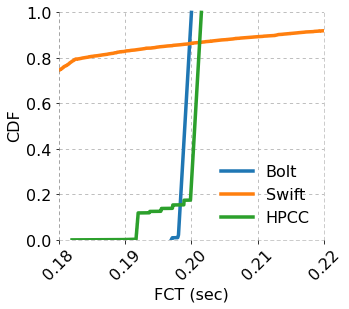

In [11]:
#@title
plt.figure(figsize=FIG_SIZE)

for algo, d in data.items():
    fct_cdf = np.arange(1,len(d['fct'])+1) / len(d['fct'])
    plt.plot(d['fct'], fct_cdf, label=algo, linewidth=3.5)

plt.ylabel('CDF', fontsize=FONTSIZE)
plt.xlabel('FCT (sec)', fontsize=FONTSIZE)
plt.xticks(rotation=45, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.ylim([0,1.01])
plt.xlim([0.18,0.22])
plt.legend(frameon=False, fontsize=FONTSIZE)
plt.grid(linestyle =LINESTYLE)
plt.gca().spines["right"].set_linestyle(LINESTYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINESTYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_linestyle(LINESTYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

if (SAVE_FIG):
    save_folder = '../outputs/bolt-star-topo-incast/'
    save_filename = 'nSenders-' + str(NUM_SENDERS) + '_'
    save_filename += 'nMsgPerSender-' + str(NUM_MSG_PER_SENDER) + '_incast_fct.pdf'

    plt.savefig(save_folder + save_filename)
plt.show()

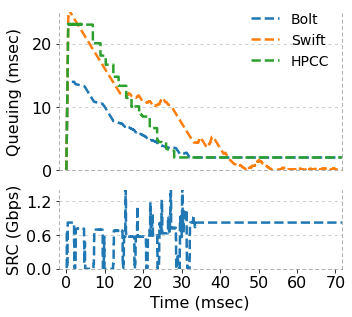

In [12]:
f, (a0, a1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

a0.grid(axis='y', alpha=0.75, linestyle=LINESTYLE)
a0.set_ylabel('Queuing (msec)', fontsize=FONTSIZE)
for algo, d in data.items():
    a0.step(d['que_times']*1e3, d['que_sizes']/1e3, label=algo, 
             where='post', linestyle='--', linewidth=LINEWIDTH)

leg = a0.legend(loc='upper right', frameon=False, ncol=1, fontsize=FONTSIZE-2,
                bbox_to_anchor=(1.0, 1.08),)
for line in leg.get_lines():
    line.set_linewidth(LINEWIDTH)
    
a0.set_ylim((0,25))
a0.set_xlim((-2,np.max(data['Bolt']['que_times'])*1e3/3.+5))
a0.spines['top'].set_visible(False)
# a0.spines['right'].set_visible(False)
a0.get_xaxis().set_visible(False)
# a0.tick_params(axis='x',label1On=False)
a0.tick_params(axis='y', which='major', labelsize=FONTSIZE)

a0.spines["right"].set_linestyle(LINESTYLE)
a0.spines["right"].set_alpha(0.75)
a0.spines["right"].set_color('gray')
a0.spines["left"].set_linestyle(LINESTYLE)
a0.spines["left"].set_alpha(0.75)
a0.spines["left"].set_color('gray')
a0.spines["top"].set_linestyle(LINESTYLE)
a0.spines["top"].set_alpha(0.75)
a0.spines["top"].set_color('gray')
a0.spines["bottom"].set_linestyle(LINESTYLE)
a0.spines["bottom"].set_alpha(0.75)
a0.spines["bottom"].set_color('gray')

a1.grid(axis='y', alpha=0.75, linestyle=LINESTYLE)
a1.set_ylabel('SRC (Gbps)', fontsize=FONTSIZE)
a1.set_xlabel('Time (msec)', fontsize=FONTSIZE)
a1.step(data['Bolt']['bts_thp_times']*1e3, data['Bolt']['bts_thp'], label='Bolt', 
        where='post', color='C0', linestyle='--', linewidth=LINEWIDTH)

a1.set_ylim((0,1.4))
a1.set_yticks([0,0.6,1.2])
# a1.legend(loc='lower center', frameon=False, ncol=4)
a1.spines['top'].set_visible(False)
# a1.spines['right'].set_visible(False)
a1.tick_params(axis='both', which='major', labelsize=FONTSIZE)

a1.spines["right"].set_linestyle(LINESTYLE)
a1.spines["right"].set_alpha(0.75)
a1.spines["right"].set_color('gray')
a1.spines["left"].set_linestyle(LINESTYLE)
a1.spines["left"].set_alpha(0.75)
a1.spines["left"].set_color('gray')
a1.spines["top"].set_linestyle(LINESTYLE)
a1.spines["top"].set_alpha(0.75)
a1.spines["top"].set_color('gray')
a1.spines["bottom"].set_linestyle(LINESTYLE)
a1.spines["bottom"].set_alpha(0.75)
a1.spines["bottom"].set_color('gray')

f.tight_layout()
f.align_ylabels()
if (SAVE_FIG):
    save_folder = '../outputs/bolt-star-topo-incast/'
    save_filename = 'nSenders-' + str(NUM_SENDERS) + '_'
    save_filename += 'nMsgPerSender-' + str(NUM_MSG_PER_SENDER) + '_incast_qlen_bts.pdf'

    plt.savefig(save_folder + save_filename)
    
plt.show()